## Temperature monitoring

This notebook is used to visualize the temperature of the battery during a 1 hour X-ray exposure experiment.

As a simple way to record the data, we took pictures of the thermocouple reader every ~2 minutes with a cell phone.

I tried to use the `pytesseract` library to extract the temperature from the images. Unfortunately, this didn't quite work (even though it worked perfectly in ChatGPT). Since it's a small dataset, I manually extracted the temperature from the images and saved it in a CSV file.

In [1]:
from pathlib import Path
from pillow_heif import register_heif_opener
import pandas as pd
import exifread
from matplotlib import rcParams
import matplotlib.pyplot as plt

Regenerate CSV?

In [2]:
overwrite_csv = False

Read in timestamps:

In [3]:
# Register HEIF opener for Pillow
register_heif_opener()

data = []
directory_path = Path().cwd()  # Replace with the path to your directory

for k, file_path in enumerate(sorted(directory_path.glob("*.HEIC"))):    
    # Extract created timestamp
    with open(file_path, "rb") as file:
        tags = exifread.process_file(file)
        created_timestamp = str(tags.get("EXIF DateTimeOriginal", "Timestamp not found"))

    data.append({"File Name": file_path.name, "Created Timestamp": created_timestamp, "Sample temperature (°C)": "", "Reference temperature (°C)": ""})

# Create a DataFrame
df = pd.DataFrame(data)

# Create relative timestamps
df["Created Timestamp"] = pd.to_datetime(df["Created Timestamp"], errors="coerce", format="%Y:%m:%d %H:%M:%S")
df = df.sort_values(by="Created Timestamp").reset_index(drop=True)
min_timestamp = df["Created Timestamp"].min()
df["Relative Timestamp (min)"] = (df["Created Timestamp"] - min_timestamp).dt.total_seconds() / 60

# Save the DataFrame to a CSV file
if overwrite_csv:
    assert 1 == 1#df.to_csv("temperature_data.csv", index=False)

print("Data processing complete. Results saved to temperature_data.csv.")

Data processing complete. Results saved to temperature_data.csv.


At this point, I manually entered the values into the CSV file.

In [4]:
# Set figure parameters
fig_width = 3.25 #ECS spec is 3.25" width
fig_width_2col_inches = 7
fig_height = (3/4)*fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 8
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['lines.markersize'] = 5
rcParams['legend.fontsize'] = 7
rcParams['xtick.bottom'] = False
rcParams['ytick.direction'] = 'in' 

Read the data back in:

In [5]:
df = pd.read_csv("temperature_data.csv")

Plot:

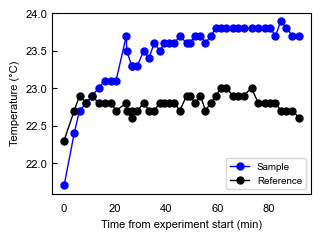

In [7]:

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

plt.plot(df["Relative Timestamp (min)"], df["Sample temperature (°C)"], marker="o", linestyle="-", color="blue", label="Sample")
plt.plot(df["Relative Timestamp (min)"], df["Reference temperature (°C)"], marker="o", linestyle="-", color="black", label="Reference")
plt.xlabel("Time from experiment start (min)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.savefig("SI temperature.pdf", dpi=300, bbox_inches="tight", format="pdf")